<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Modelos polarimetría Mueller </font>
</div>

- **Para**: Paper calibración SLM Mueller

- **Fecha**: 2023/01/26
        
- **Autores**: Jesús del Hoyo

- **Objetivos**: Tener un resumen claro de los modelos de polarimetría Mueller de la literatura y nuestro.

- **Descripción** 

- **Referencias**: Al final del todo.


# Métodos cuasi perfectos

En el documento 03 Extensión de métodos Stokes-Mueller he visto que el condition number es idéntico si se usan sólidos regulares para distribuir los estados del PSG y del PSA. Vamos a comprobar cómo se aleja el condition number del valor ideal si introducimos un cierto ruido en la colocación de esos estados.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import optimize
import sympy as sy
from copy import deepcopy
from pyswarms.single.global_best import GlobalBestPSO
from itertools import combinations

from py_pol.mueller import Mueller, Stokes, degrees
from py_lab.config import angle_P1, angle_Q1, angle_Q2, angle_P2
from py_lab.utils import PSA_states_2_angles, PSG_states_2_angles, PSA_angles_2_states, PSG_angles_2_states
import matplotlib.pyplot as plt

In [4]:
def W_from_S(S_PSG, S_PSA):
    """Funcion para calcular la matriz W a partir de los estados del PSG y del PSA.

    Args:
        S_PSG (Stokes): States of the PSG.
        S_PSA (Stokes): States of the PSA.

    Returns:
        W (np.ndarray): W matrix.
    """
    # Prealocate matrix
    N = S_PSA.size * S_PSG.size
    W = np.zeros((N,16))

    # Calculate matrix
    ind = 0
    for ind_G in range(S_PSG.size):
        for ind_A in range(S_PSA.size):
            # Calculate row
            MA = S_PSA.M[:,ind_A, np.newaxis]
            MG = S_PSG.M[np.newaxis,:,ind_G]
            M = MA @ MG

            # Assign row
            W[ind,:] = 0.5 * M.flatten()
            ind += 1

    return W

In [5]:
def W_from_S_with_error(S_PSG, S_PSA, error):
    """Funcion para calcular la matriz W a partir de los estados del PSG y del PSA.

    Args:
        S_PSG (Stokes): States of the PSG.
        S_PSA (Stokes): States of the PSA.
        error (float): Error amplitude.

    Returns:
        W (np.ndarray): W matrix.
    """
    # Prealocate matrix
    N = S_PSA.size * S_PSG.size
    W = np.zeros((N,16))

    # Calculate matrix
    ind = 0
    for ind_G in range(S_PSG.size):
        s_PSG = S_PSG[ind_G]
        for ind_A in range(S_PSA.size):
            s_PSA = S_PSG[ind_A]

            # Add error
            az, el = s_PSG.parameters.azimuth_ellipticity()
            if np.isnan(az):
                az = np.random.rand() * 180*degrees
            az = az + error * np.random.randn()
            el = el + error * np.random.randn()
            s_PSG = Stokes().general_azimuth_ellipticity(azimuth=az, ellipticity=el)

            az, el = s_PSA.parameters.azimuth_ellipticity()
            if np.isnan(az):
                az = np.random.rand() * 180*degrees
            az = az + error * np.random.randn()
            el = el + error * np.random.randn()
            s_PSA = Stokes().general_azimuth_ellipticity(azimuth=az, ellipticity=el)

            # Calculate row
            MA = s_PSA.M[:,0, np.newaxis]
            MG = s_PSG.M[np.newaxis,:,0]
            M = MA @ MG

            # Assign row
            W[ind,:] = 0.5 * M.flatten()
            ind += 1

    return W

In [6]:
def W_inv(W):
    """Calculate the inverse or pseudoinverse matrix of W.

    Args:
        W (np.ndarray): W matrix to invert.

    Returns:
        Wi (np.ndarray): Inverse matrix.
    """
    # Caso N = 16
    if W.shape[0] == W.shape[1]:
        if np.linalg.matrix_rank(W) == W.shape[0]:
            Wi = np.linalg.inv(W)
        else:
            print("WARNING: Non-invertible matrix")
            return W
    # Casos N > 16
    else:
        Wi = np.linalg.inv(W.T @ W) @ W.T

    return Wi

In [7]:
def norma_Frobenius(W):
    """Norma de Frobenius.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        n (float): Norma de la matriz.
    """
    return np.linalg.norm(W)

def norma_Vect2(W):
    """Norma vectorial de orden dos.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        n (float): Norma de la matriz.
    """
    _, singular, _ = np.linalg.svd(W)
    return singular.max()/singular.min()

def condition_number(W, f_norma):
    """Calcula el condition number de una matriz NxM.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        kappa (float): Condition number
    """
    Wi = W_inv(W)
    return f_norma(W) * f_norma(Wi) # / (W.shape[0]/16)**(1)

In [8]:
# Estados
phi = (1+np.sqrt(5))/2
r3 = np.sqrt(3)
raiz = np.sqrt(1 + phi**2)

Tetraedro = np.array([[1, 1, 0, 0], [1, -1/3, np.sqrt(8)/3, 0], [1, -1/3, -np.sqrt(2)/3, np.sqrt(6)/3], [1, -1/3, -np.sqrt(2)/3, -np.sqrt(6)/3]]).T
Octaedro = np.array([[1, 1, 0, 0], [1, -1, 0, 0], [1, 0, 1, 0], [1, 0, -1, 0], [1, 0, 0, 1], [1, 0, 0, -1] ]).T
Cubo = np.array([[r3, 1, 1, 1], [r3, 1, 1, -1], [r3, 1, -1, 1], [r3, -1, 1, 1], [r3, -1, -1, 1], [r3, -1, 1, -1], [r3, 1, -1, -1], [r3, -1, -1, -1]]) / r3
Icosaedro = np.array([[raiz, 0, 1, phi], [raiz, 0, -1, phi], [raiz, 0, 1, -phi], [raiz, 0, -1, -phi], 
    [raiz, 1, phi, 0], [raiz, -1, phi, 0], [raiz, 1, -phi, 0], [raiz, -1, -phi, 0],
    [raiz, phi, 0, 1], [raiz, -phi, 0, 1], [raiz, phi, 0, -1], [raiz, -phi, 0, -1],
]) / raiz
Dodecaedro = np.array([[r3, 1, 1, 1], [r3, 1, 1, -1], [r3, 1, -1, 1], [r3, -1, 1, 1], [r3, -1, -1, 1], [r3, -1, 1, -1], [r3, 1, -1, -1], [r3, -1, -1, -1], 
    [r3, 0, phi, 1/phi], [r3, 0, -phi, 1/phi], [r3, 0, phi, -1/phi], [r3, 0, -phi, -1/phi], 
    [r3, 1/phi, 0, phi], [r3, -1/phi, 0, phi], [r3, 1/phi, 0, -phi], [r3, -1/phi, 0, -phi], 
    [r3, phi, 1/phi, 0], [r3, -phi, 1/phi, 0], [r3, phi, -1/phi, 0], [r3, -phi, -1/phi, 0], ]) / r3

S_4 = Stokes().from_matrix(Tetraedro)
S_6 = Stokes().from_matrix(Octaedro)
S_8 = Stokes().from_matrix(Cubo)
S_12 = Stokes().from_matrix(Icosaedro)
S_20 = Stokes().from_matrix(Dodecaedro)
lista = [S_4, S_6, S_8, S_12, S_20]

In [9]:
def put_in_limits(az, el):
    """Funcion para colocar el acimut y la elipticidad dentro de sus limites teniendo en cuenta cambios conjuntos.

    Args:
        az (np.ndarray): Acimut
        el (np.ndarray): Angulo de elipticidad.

    Returns:
        az, el (np.ndarray())
    """
    # Elipticidad
    aux = np.tan(el)
    cond = np.abs(aux) > 1
    if len(cond) > 0:
        el[cond] = np.arctan(1/aux[cond])
        az[cond] = az[cond] + 90*degrees
    # Acimut
    az = az % (180*degrees)
    return az,el

In [10]:
az, el = put_in_limits(np.array([50*degrees]), np.array([-50*degrees]))
print(az/degrees, el/degrees)

[140.] [-40.]


## 1. Error en grupos de estados

Vamos a introducir errores en los estados del PSG y del PSA pero en grupo. Es decir, si cambio el estado 1 del PSG, el cambio es el mismo para todas las combinaciones en que se usa ese estado.

### 1.A Cambio igual para el PSG que para el PSA

Si cambiamos el estado 1 del PSG, el estado 1 del PSA cambia de la misma manera. Solo es válido para métodos en que el numero de estados del PSG y del PSA es el mismo.

In [11]:
# Combinaciones
Naverage = 100
Nstates = len(lista)
Nerrores = 21
MaxError = 5*degrees
errorAmp = np.linspace(0, MaxError, Nerrores)
kappa = np.ones((Nstates,Nerrores)) * 9
kappa_error = np.zeros((Nstates,Nerrores))

for indS, S in enumerate(lista):
    for indE, error in enumerate(errorAmp[1:]):
        kappa_aux = np.ones(Naverage) * 9
        az, el = S.parameters.azimuth_ellipticity()
        cond = np.isnan(az)
        if np.any(cond) > 0:
            az[cond] = np.random.rand(np.sum(cond)) * 180*degrees
        for indA in range(Naverage):
            # Add error
            az_part = az + error*np.random.randn(az.size)
            el_part = el + error*np.random.randn(el.size)
            az_part, el_part = put_in_limits(az_part, el_part)
            # Calculate state
            S_exp = Stokes().general_azimuth_ellipticity(azimuth=az_part, ellipticity=el_part)
            # Calculate kappa
            W = W_from_S(S_exp, S_exp)
            kappa_aux[indA] = condition_number(W, norma_Vect2)
            
        # Media del condition number
        kappa[indS, indE+1] = np.mean(kappa_aux)
        kappa_error[indS, indE+1] = np.std(kappa_aux)



In [13]:
plt.figure(figsize=(12,6))
for ind in range(Nstates):
    plt.errorbar(x=errorAmp/degrees, y=kappa[ind,:], yerr=kappa_error[ind,:], capsize=5)
plt.xlabel("Error amp. (deg)")
plt.ylabel("Cond. number")
plt.legend(("4x4", "6x6", "8x8", "12x12", "20x20" ))
plt.ylim([8, 24])

(8.0, 24.0)

El condition number aumenta más cuanto menos medidas hay pese a que la amplitud del error es igual.

### 1.B Cambio diferente para el PSG que para el PSA

Ahora el cambio es diferente.

In [60]:
# Combinaciones
Naverage = 100
Nstates = len(lista)
Nerrores = 21
MaxError = 5*degrees
errorAmp = np.linspace(0, MaxError, Nerrores)
kappa = np.ones((Nstates,Nerrores)) * 9
kappa_error = np.zeros((Nstates,Nerrores))

for indS, S in enumerate(lista):
    for indE, error in enumerate(errorAmp[1:]):
        kappa_aux = np.ones(Naverage) * 9
        az, el = S.parameters.azimuth_ellipticity()
        cond = np.isnan(az)
        if np.any(cond) > 0:
            az[cond] = np.random.rand(np.sum(cond)) * 180*degrees
        for indA in range(Naverage):
            # Add error PSA
            az_part = az + error*np.random.randn(az.size)
            el_part = el + error*np.random.randn(el.size)
            az_part, el_part = put_in_limits(az_part, el_part)
            S_PSA = Stokes().general_azimuth_ellipticity(azimuth=az_part, ellipticity=el_part)
            # Add error PSG
            az_part = az + error*np.random.randn(az.size)
            el_part = el + error*np.random.randn(el.size)
            az_part, el_part = put_in_limits(az_part, el_part)
            S_PSG = Stokes().general_azimuth_ellipticity(azimuth=az_part, ellipticity=el_part)
            # Calculate kappa
            W = W_from_S(S_PSG, S_PSA)
            kappa_aux[indA] = condition_number(W, norma_Vect2)
            
        # Media del condition number
        kappa[indS, indE+1] = np.mean(kappa_aux)
        kappa_error[indS, indE+1] = np.std(kappa_aux)

(8.0, 24.0)

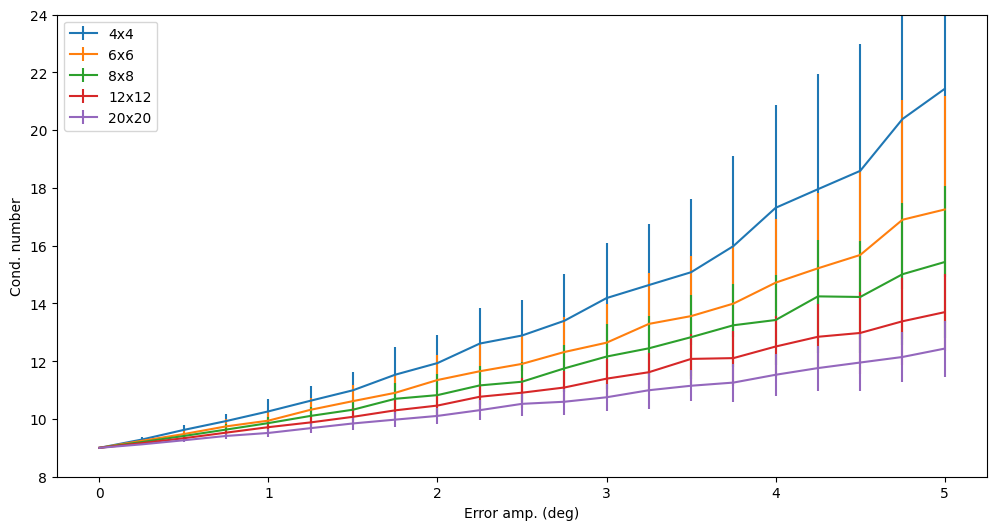

In [61]:
plt.figure(figsize=(12,6))
for ind in range(Nstates):
    plt.errorbar(x=errorAmp/degrees, y=kappa[ind,:], yerr=kappa_error[ind,:], capsize=5)
plt.xlabel("Error amp. (deg)")
plt.ylabel("Cond. number")
plt.legend(("4x4", "6x6", "8x8", "12x12", "20x20" ))
plt.ylim([8, 24])

## 2 Error en cada medida

En este caso voy a introducir un error en los estados individualmente.

In [14]:
# Combinaciones
Naverage = 100
Nstates = len(lista)
Nerrores = 21
MaxError = 5*degrees
errorAmp = np.linspace(0, MaxError, Nerrores)
kappa = np.ones((Nstates,Nerrores)) * 9
kappa_error = np.zeros((Nstates,Nerrores))

for indS, S in enumerate(lista):
    for indE, error in enumerate(errorAmp[1:]):
        for indA in range(Naverage):
            # Calculate kappa
            W = W_from_S_with_error(S, S, error)
            kappa_aux[indA] = condition_number(W, norma_Vect2)
            
        # Media del condition number
        kappa[indS, indE+1] = np.mean(kappa_aux)
        kappa_error[indS, indE+1] = np.std(kappa_aux)

In [17]:
plt.figure(figsize=(12,6))
for ind in range(Nstates):
    plt.errorbar(x=errorAmp/degrees, y=kappa[ind,:], yerr=kappa_error[ind,:], capsize=5)
plt.xlabel("Error amp. (deg)")
plt.ylabel("Cond. number")
plt.legend(("4x4", "6x6", "8x8", "12x12", "20x20" ))
plt.ylim([8, 50])

(8.0, 50.0)

El resultado es el mismo pero con errores más altos y más ruido. En ambos casos parece que el crecimiento es cuadrático.